## Sampling Notebook + .PT => .JSON

This is a quick generation script to check on how the training run is going. Kind of a mess of prototype code, but it works.

Sampling on device: mps


Sampling: 100%|██████████| 32/32 [00:01<00:00, 30.50it/s]


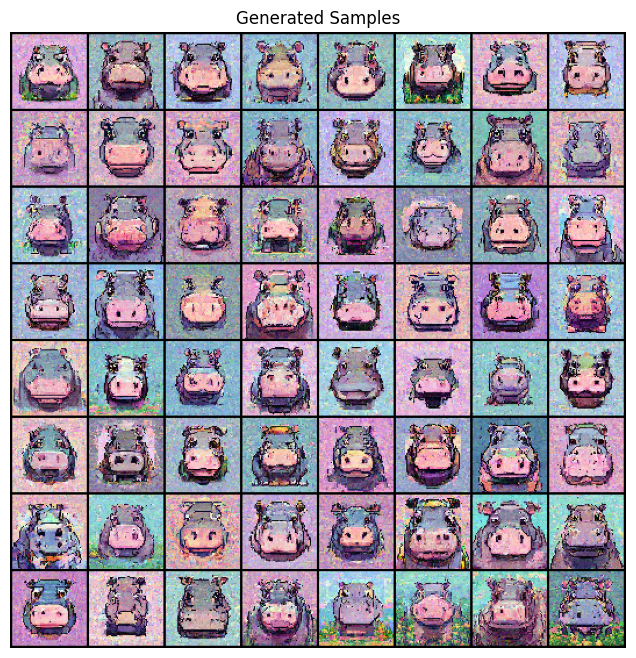

In [2]:

import torch
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Import model definitions (DiT and its config) from your dit.py file.
from dit import DiT, DiTConfig

# Define the same config as used in training.
config = {
    "input_size": 64,
    "patch_size": 8,
    "in_channels": 3,
    "dim": 512,
    "depth": 4,
    "dim_head": 128,
    "mlp_mult": 4,
    "time_emb_dim": 128,
    "timesteps": 32,       
    "beta_start": 1e-4,     
    "beta_end": 0.02,
    "lr": 1e-4,
    "batch_size": 64,       
    "epochs": 10000,
    "dataset_path": "hippo_images"
}

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Sampling on device:", device)

# Define the noise schedule builder (identical to your training script).
def get_noise_schedule(timesteps, device, s=0.008):
    # Add one extra time step for the cumulative product.
    steps = timesteps + 1
    t_lin = torch.linspace(0, timesteps, steps, device=device) / timesteps

    # Cosine schedule for the cumulative product.
    alphas_cumprod = torch.cos(((t_lin + s) / (1 + s)) * (math.pi * 0.5)) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Derive betas from the cumulative schedule.
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clamp(betas, 0, 0.999)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_bars

# (Re)build your DiT model using the same configuration.
model_config = DiTConfig(
    input_size=config["input_size"],
    patch_size=config["patch_size"],
    in_channels=config["in_channels"],
    dim=config["dim"],
    depth=config["depth"],
    dim_head=config["dim_head"],
    mlp_mult=config["mlp_mult"],
    time_emb_dim=config["time_emb_dim"],
)
model = DiT(model_config).to(device)

# Load your trained checkpoint (adjust the path if needed).
checkpoint = torch.load("dit_epoch_100.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Build the noise schedule (using beta_start as the s parameter).
T = config["timesteps"]
betas, alphas, alpha_bars = get_noise_schedule(T, device, s=config["beta_start"])

# Set the number of images to generate.
sample_batch_size = config["batch_size"]

# ----------------------------------------------------------------------------
# Sampling Loop (reverse diffusion):
# ----------------------------------------------------------------------------
# We start from pure Gaussian noise (x_T) in the same shape as your training images.
x = torch.randn(sample_batch_size, config["in_channels"], config["input_size"], config["input_size"], device=device)

# Here we perform T reverse diffusion steps.
# The reverse update uses the standard DDPM formula:
#   mu = 1/sqrt(alpha_t) * ( x_t - (beta_t/sqrt(1-alpha_bar_t))*pred_noise )
#   x_{t-1} = mu + (sqrt(beta_t)*noise)    (if t > 0, with no noise added when t == 0)
for t in tqdm(reversed(range(T)), total=T, desc="Sampling"):
    # Create a tensor for the current time-step (as float for the time embedding).
    t_tensor = torch.full((sample_batch_size,), t, device=device, dtype=torch.float32)
    
    # Predict the noise from the current noisy image.
    with torch.no_grad():
        pred_noise, _ = model(x, t_tensor)
        
    # Get (scalar) schedule values at time t.
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]
    
    # Compute the mean (mu) of the reverse transition.
    sqrt_recip_alpha_t = 1.0 / torch.sqrt(alpha_t)
    coef = beta_t / torch.sqrt(1 - alpha_bar_t)
    mu = sqrt_recip_alpha_t * (x - coef * pred_noise)
    
    # For t > 0, add noise. For t == 0, no noise is added.
    if t > 0:
        noise = torch.randn_like(x)
        x = mu + torch.sqrt(beta_t) * noise
    else:
        x = mu

# ----------------------------------------------------------------------------
# Postprocessing and display:
# ----------------------------------------------------------------------------
# The generated images are in the [-1, 1] range; map them back to [0, 1].
x = (x + 1) / 2
x = x.clamp(0, 1)

# Create a grid of images for display.
grid = make_grid(x, nrow=8)  # e.g. an 8x8 grid if sample_batch_size==64

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Generated Samples")
plt.show()

In [4]:
import struct
import numpy as np

def export_weights_binary(model, filename):
    d = model.export_matrices()
    with open(filename, 'wb') as f:
        # Write a magic header.
        f.write(b'WTS1')
        # Write number of weights.
        f.write(struct.pack('<I', len(d)))
        for key, value in d.items():
            arr = np.array(value.cpu().detach(), dtype=np.float32)
            key_bytes = key.encode('utf-8')
            # Write the key’s length and key bytes.
            f.write(struct.pack('<I', len(key_bytes)))
            f.write(key_bytes)
            # Pad the key bytes so that key_bytes length is a multiple of 4.
            padding = (4 - (len(key_bytes) % 4)) % 4
            f.write(b'\0' * padding)
            # Write the number of dimensions.
            f.write(struct.pack('<I', arr.ndim))
            # Write each dimension size.
            for dim in arr.shape:
                f.write(struct.pack('<I', int(dim)))
            # Write the total number of elements.
            f.write(struct.pack('<I', arr.size))
            # Write the raw float32 data.
            f.write(arr.tobytes())

# Export the model weights to a binary file.
export_weights_binary(model, "matrices.bin")

In [67]:
# convert model parameters to fp4 to test for precision issues
model = model.half()
model = model.to('mps')
model = model.half()

In [4]:
# blank forward pass to align torch model implementation w/ webGPU

# do a forward pass to get the matrices
#x = torch.randn(1, 3, 64, 64).to(device)
test = model(torch.ones((1,3,64,64)).to(device), torch.tensor([1], device=device)).detach().cpu()
print(test.shape)
# mean std min max
print(f"Mean: {test.mean()}")
print(f"Std: {test.std()}")
print(f"Min: {test.min()}")
print(f"Max: {test.max()}")


x before blocks
flattened length: torch.Size([32768])
shape: torch.Size([1, 64, 512])
mean: 0.46283814311027527
std: 5.382679462432861
min: -46.3148078918457
max: 100.08164978027344
first 5: tensor([ -0.1633,   3.0462, -45.3889,   1.8915,  -4.2882], device='mps:0',
       grad_fn=<SliceBackward0>)
time_emb before blocks
flattened length: torch.Size([128])
shape: torch.Size([1, 128])
mean: -0.001597814029082656
std: 0.04537370428442955
min: -0.45696187019348145
max: 0.14994385838508606
first 5: tensor([ 0.1499, -0.0021,  0.0007, -0.4570,  0.0009], device='mps:0',
       grad_fn=<SliceBackward0>)
STARTING BLOCK, norm next
scale
flattened length: torch.Size([512])
shape: torch.Size([1, 1, 512])
mean: 0.10590691864490509
std: 0.20622627437114716
min: -0.18235111236572266
max: 2.368884325027466
first 5: tensor([2.3689, 0.1321, 0.0940, 0.1399, 0.0115], device='mps:0',
       grad_fn=<SliceBackward0>)
shift
flattened length: torch.Size([512])
shape: torch.Size([1, 1, 512])
mean: 0.00224714679

In [4]:
from torch.functional import F

# test end to end loss between torch and webGPU
F.mse_loss(x.reshape(1, 3, 64, 64), test)

NameError: name 'x' is not defined